# Training and Validation Set Generator

## Imports

In [1]:
# Math and Plotting
import numpy as np                         
import matplotlib.pyplot as plt             
# from pyscenarios.sobol import sobol  
from scipy import constants, interpolate
%matplotlib inline
import itertools
import math

# Basic Data Imports
import time
from pickle import dump, load    
import pandas as pd

# RDF Analysis and Simulations
# import freud
import gsd.hoomd
import hoomd
from utility.rdf_analysis import rdf2sq

# Parallel Computing
# import dask
# from dask.distributed import Client, progress
# from matplotlib.pyplot import figure
# from dask import config as cfg

## Simulation Functions

In [2]:
def snap_molecule_indices(snap):
    """Find molecule index for each particle.

    Given a snapshot from a trajectory, compute clusters of bonded molecules
    and return an array of the molecule index of each particle.

    Parameters
    ----------
    snap : gsd.hoomd.Snapshot
        Trajectory snapshot.

    Returns
    -------
    numpy array (N_particles,)

    """
    system = freud.AABBQuery.from_system(snap)
    num_query_points = num_points = snap.particles.N
    query_point_indices = snap.bonds.group[:, 0]
    point_indices = snap.bonds.group[:, 1]
    distances = system.box.compute_distances(
        system.points[query_point_indices], system.points[point_indices]
    )
    nlist = freud.NeighborList.from_arrays(
        num_query_points, num_points, query_point_indices, point_indices, distances
    )
    cluster = freud.cluster.Cluster()
    cluster.compute(system=system, neighbors=nlist)
    return cluster.cluster_idx


def intermolecular_rdf( gsdfile, A_name, B_name, start=0, stop=None, r_max=None, r_min=0, bins=1000, exclude_bonded=True):
    """Compute intermolecular RDF from a GSD file.

    This function calculates the radial distribution function given a GSD file
    and the names of the particle types. By default it will calculate the RDF
    for the entire trajectory.

    It is assumed that the bonding, number of particles, and simulation box do
    not change during the simulation. (Note: Exclude Bonded Feature most likley broken with hoomd 4.1.0 - Hopefner Group)

    Parameters
    ----------
    gsdfile : str
        Filename of the GSD trajectory.
    A_name, B_name : str
        Name(s) of particles between which to calculate the RDF (found in
        gsd.hoomd.Snapshot.particles.types)
    start : int
        Starting frame index for accumulating the RDF. Negative numbers index
        from the end. (Default value = 0)
    stop : int
        Final frame index for accumulating the RDF. If None, the last frame
        will be used. (Default value = None)
    r_max : float
        Maximum radius of RDF. If None, half of the maximum box size is used.
        (Default value = None)
    r_min : float
        Minimum radius of RDF. (Default value = 0)
    bins : int
        Number of bins to use when calculating the RDF. (Default value = 100)
    exclude_bonded : bool
        Whether to remove particles in same molecule from the neighbor list.
        (Default value = True)

    Returns
    -------
    freud.density.RDF
    """
    with gsd.hoomd.open(name = gsdfile, mode = 'r') as trajectory:
        snap = trajectory[0]

        if r_max is None:
            # Use a value just less than half the maximum box length.
            r_max = np.nextafter(
                np.max(snap.configuration.box[:3]) * 0.5, 0, dtype=np.float32
            )

        rdf = freud.density.RDF(bins=bins, r_max=r_max, r_min=r_min)

        type_A = snap.particles.typeid == snap.particles.types.index(A_name)
        type_B = snap.particles.typeid == snap.particles.types.index(B_name)

        if exclude_bonded:
            molecules = snap_molecule_indices(snap)
            molecules_A = molecules[type_A]
            molecules_B = molecules[type_B]

        for snap in trajectory[start:stop]:

            A_pos = snap.particles.position[type_A]
            if A_name == B_name:
                B_pos = A_pos
                exclude_ii = True
            else:
                B_pos = snap.particles.position[type_B]
                exclude_ii = False

            box = snap.configuration.box
            system = (box, A_pos)
            aq = freud.locality.AABBQuery.from_system(system)
            nlist = aq.query(
                B_pos, {"r_max": r_max, "exclude_ii": exclude_ii}
            ).toNeighborList()

            if exclude_bonded:
                pre_filter = len(nlist)
                indices_A = molecules_A[nlist.point_indices]
                indices_B = molecules_B[nlist.query_point_indices]
                nlist.filter(indices_A != indices_B)
                post_filter = len(nlist)

            rdf.compute(aq, neighbors=nlist, reset=False)
        normalization = post_filter / pre_filter if exclude_bonded else 1
        return rdf, normalization
    
def run_simulation(i,xs_filename):
    
    # Reload Samples
    input_dict = load(open(xs_filename, 'rb'))
    xs = input_dict['xs']
    nsamps = len(xs[:,0])
    ndims  = len(xs[0,:])
    
    #Thermodynamic state variables
    k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
    av  = 6.0223e23      #avagadro number,      [particle/mol]  
    T   = 42.2           #temperature,          [K]
    kbT = k * av * T     #thermal energy,       [kcal/mol]
    ρ   = 0.02477        #experimental density, [particle/Å^3]   
    
    t1 = time.time()
    
    # Defines the parameters of the box
    m = 6
    N_particles = 4 * m**3
    spacing = 6
    K = math.ceil(N_particles**(1 / 3))
    L = K * spacing * xs[i%nsamps][1] # \sigma
    x = np.linspace(-L / 2, L / 2, K, endpoint=False)
    position = list(itertools.product(x, repeat=3))

    # Use the parameters to feed into a Hoomd frame
    frame = gsd.hoomd.Frame()
    frame.particles.N = N_particles
    frame.particles.position = position[0:N_particles]
    frame.particles.typeid = [0] * N_particles
    frame.configuration.box = [L, L, L, 0, 0, 0]
    frame.particles.types = ['A']
    with gsd.hoomd.open(name='lattice_folder/lattice_' + str(i) +'.gsd', mode='w') as f:
        f.append(frame)

    # Simulation settings, Integrator, Force Field, Simulation Object, etc. 
    cpu = hoomd.device.CPU()
    sim = hoomd.Simulation(device=cpu, seed=1)
    sim.create_state_from_gsd(filename='lattice_folder/lattice_' + str(i) +'.gsd')
    dt = 0.005
    integrator = hoomd.md.Integrator(dt=dt)
    cell = hoomd.md.nlist.Cell(buffer=0.4)

    # Force Field Inputs
    mie = hoomd.md.pair.Mie(nlist=cell)
    mie.params[('A', 'A')] = dict(epsilon=xs[i%nsamps][2], sigma=xs[i%nsamps][1], n=xs[i%nsamps][0], m=6)
    mie.r_cut[('A', 'A')] = 3*xs[i%nsamps][1]
    integrator.forces.append(mie)

    # Thermostat settings
    mttk = hoomd.md.methods.thermostats.MTTK(kT=kbT, tau=100*dt) # Nose-Hoover
    nvt = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All(),
    thermostat=mttk)
    integrator.methods.append(nvt)
    sim.operations.integrator = integrator
    
    # Thermalization
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kbT)
    sim.run(5_000)
    
    # Resizing box to hit target density
    ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=10_000)
    rho = sim.state.N_particles / sim.state.box.volume
    initial_box = sim.state.box
    final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
    final_rho = ρ
    final_box.volume = sim.state.N_particles / final_rho
    box_resize_trigger = hoomd.trigger.Periodic(10)
    box_resize = hoomd.update.BoxResize(box1=initial_box, box2=final_box, variant=ramp, trigger=box_resize_trigger)
    sim.operations.updaters.append(box_resize)
    sim.run(10_000)
    
    
    # Equilibrating with finalized simulation settings
    sim.operations.updaters.remove(box_resize)
    sim.run(50_000)

    # Add data collection to simulation, Thermodynamic Properties and RDF
    gsd_writer = hoomd.write.GSD(filename='sim_trajectories/mie_' + str(i) + '.gsd',
                              trigger=hoomd.trigger.Periodic(1000),
                              mode='wb')
    sim.operations.writers.append(gsd_writer)
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)
    logger = hoomd.logging.Logger()
    logger.add(thermodynamic_properties)
    gsd_writer.log = logger
    
    # Run Simulation
    sim.run(5e5)

    #IMPORTANT, YOU MUST FLUSH IN ORDER FOR THE GSD WRITER TO PUT DATA IN THE FILE
    gsd_writer.flush()
    
    # Save Collected data. 
    rdf, normalization = intermolecular_rdf('sim_trajectories/mie_' + str(i) + '.gsd', 'A', 'A', r_max=0.95*((N_particles/ρ)**(1/3))/2, exclude_bonded=False)
    
    t2 = time.time()
    
    returnDict = dict()
    returnDict['model_rdf'] = rdf.rdf
    returnDict['t'] = t2-t1
    returnDict['r'] = rdf.bin_centers
    
    return returnDict

## Experimental Structure

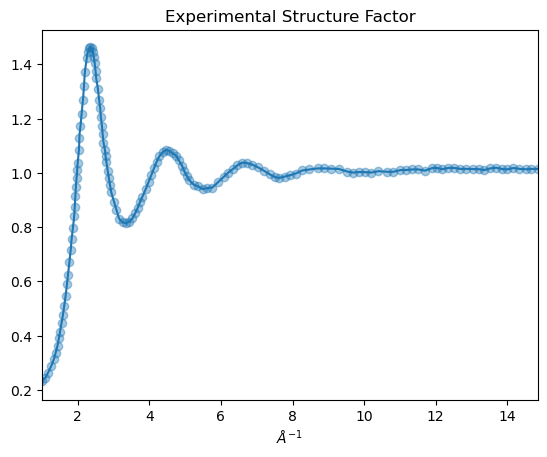

In [3]:
# Read in Experimental Data
data = pd.read_csv('exp_data/ne_42K_sq_new.csv')
q_exp_raw = np.array(data['s'])
sq_exp_raw = np.array(data['q'])

qmin = q_exp_raw[0]
qmax = q_exp_raw[-1]
qnum = 1000

# Interpolate it to make it have a uniform q dist.
q_exp  = np.linspace(qmin, qmax, num=qnum)
sq_exp = np.interp(q_exp, q_exp_raw, sq_exp_raw)


plt.title("Experimental Structure Factor")
plt.scatter(q_exp_raw,sq_exp_raw,alpha=0.4,label = "Raw Data")
plt.plot(q_exp, sq_exp,label = "Interpolation")
plt.xlim(1,q_exp[-1])
plt.xlabel("$\AA^{-1}$")
plt.show()

# Define density for later
ρ   = 0.02477 #experimental density, [particle/Å^3]   

Old length:  155
New length:  1000


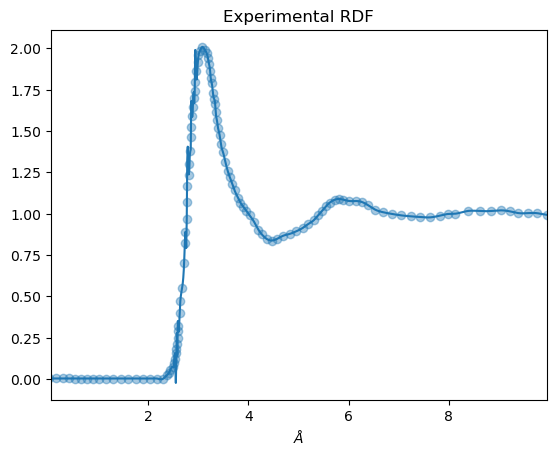

In [4]:
experimentalCSVFilename = 'exp_data/ne_42K_rdf_new.csv'

data = pd.read_csv(experimentalCSVFilename)
r_exp_raw = np.array(data['r'])
rdf_exp_raw = np.array(data[' g'])

rmin = 0.052707306
rmax = 9.957716702
rnum = 1000

# Interpolalate the experimental data to make it consistent with the simulations
r  = np.linspace(rmin, rmax, num=rnum)
rdf_exp_i = interpolate.splrep(r_exp_raw, rdf_exp_raw, s=0)
rdf_exp = interpolate.splev(r, rdf_exp_i, der=0)

print("Old length: ", len(r_exp_raw))
print("New length: ", len(r))

plt.title("Experimental RDF")
plt.scatter(r_exp_raw,rdf_exp_raw,alpha=0.4)
plt.plot(r, rdf_exp)
plt.xlim(rmin,rmax)
plt.xlabel("$\AA$")
plt.show()

In [5]:
print("qmin:",qmin)
print("qmax:",qmax)
print("qnum:",qnum)
print()
print("rmin:",rmin)
print("rmax:",rmax)
print("rnum:",rnum)

qmin: 0.7229127476661802
qmax: 14.850872874949454
qnum: 1000

rmin: 0.052707306
rmax: 9.957716702
rnum: 1000


## Initial GP Training Set Input Space

Use pseudorandom sobol sampling to get samples within a given range. These should be chosen to be larger than the expected posterior evaluation range. GPs are for interpolation and not extrapolation, hence the buffer reigon. There is only going to be 50 evaluations within this larger reigon. Then the range will be shrunk according to the one with minimum error wrt to the experimental structure measurement. 

load success


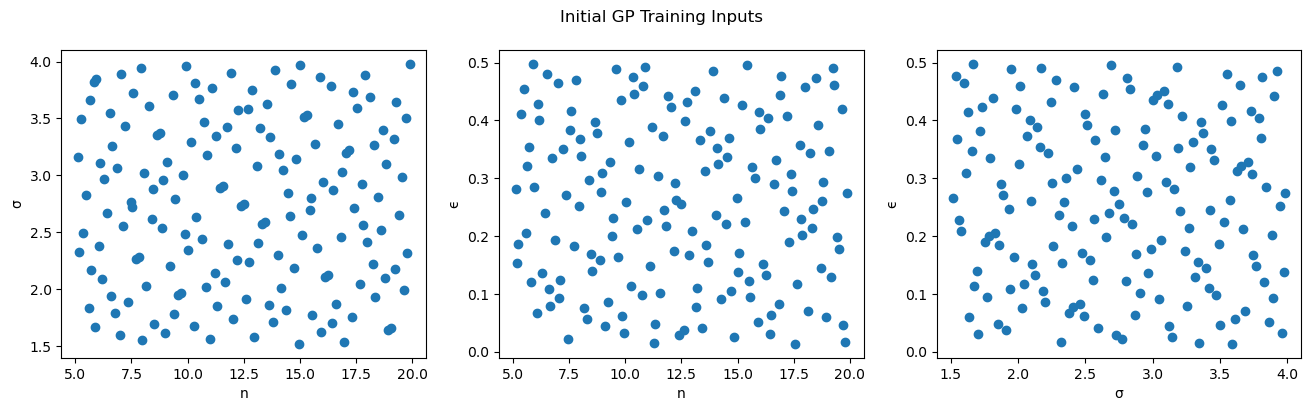

In [6]:
ndims = 3          #number of model parameters
nsims = 160        #number of training simulations

# Rescale ranges
ranges_init = np.array([[5.0, 20.0],
                        [1.5, 4],
                        [0.01, 0.5]])
try:
    input_dict = load(open('training_data/samples_init.p', 'rb'))
    xs_init = input_dict['xs']
    print('load success')
except:

    # Generate samples of the correct dimensions
    xs_init = sobol((nsims, ndims))
    xs_init = ranges_init[:, 0] + xs_init * (ranges_init[:, 1] - ranges_init[:, 0])

    # Save the input samples
    output_dict = dict(xs = xs_init)
    dump(output_dict, open('training_data/samples_init.p', 'wb'))

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.suptitle("Initial GP Training Inputs")
axs[0].scatter(xs_init[:, 0], xs_init[:, 1])
axs[0].set_xlabel('n')
axs[0].set_ylabel('σ')
axs[1].scatter(xs_init[:, 0], xs_init[:, 2])
axs[1].set_xlabel('n')
axs[1].set_ylabel('ϵ')
axs[2].scatter(xs_init[:, 1], xs_init[:, 2])
axs[2].set_xlabel('σ')
axs[2].set_ylabel('ϵ')
plt.show()

## Simulation Loop

In [7]:
# Try to load previously computed simulation data 
try: 
    input_dict = load(open('training_data/training_rdf_init.p', 'rb'))
    totalResults = input_dict['totalResults']
    totalTime = input_dict['totalTime']
    print('load success')

# If not run them
except:

    cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
    client = Client(threads_per_worker=1, n_workers=40)
    
    xs_filename = 'training_data/samples_init.p'

    # Queue up function calls into dask
    lazy_results = []
    for i in range (nsims):
        lazy_results.append(dask.delayed(run_simulation)(i,xs_filename))

    # Split the dask calls to run 4 sets of 40 sims
    t1 = time.time()

    totalResults = []
    i = 0
    while i < 160:
        
        # Allow dask to parallelize the set of simulations and run them
        results = dask.compute(*lazy_results[i:(i+40)])
        totalResults.append(results)
        i += 40        

    t2 = time.time()
    totalTime = (t2-t1)
    
    output_dict = dict(totalResults = totalResults, totalTime = (t2 - t1))
    dump(output_dict, open('training_data/training_rdf_init.p', 'wb'))

results = []
for result_i in totalResults:
    for outDict in result_i:
        results.append(outDict)

load success


## Results

Total Time Taken for 160 Sims:  18318.50271296501
Average Time =  114.49064195603133
Average Simulation Time:  2606.6509968340397


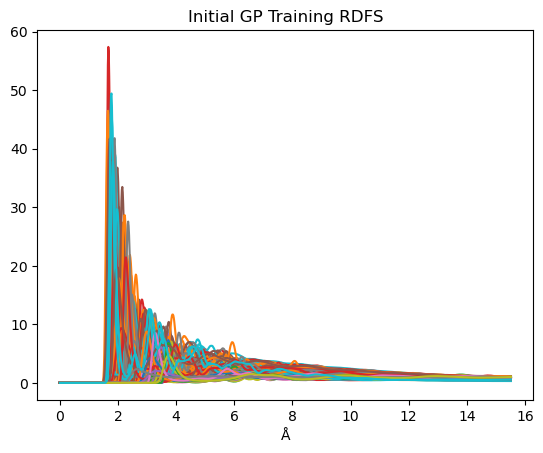

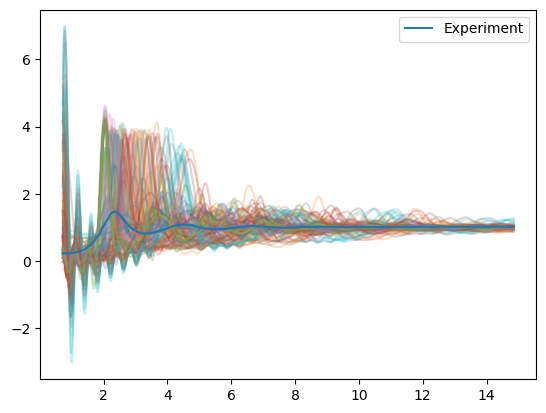

Best set of Mie parameters from training set:  [12.3828125   2.73046875  0.02914063]


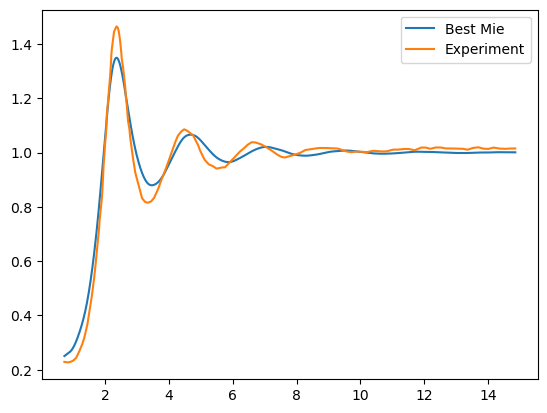

In [8]:
print("Total Time Taken for 160 Sims: ", totalTime)
print("Average Time = ", totalTime/160)
# Display RDFs and compute average time for simulation
tAvgInit = 0
modelRDFInit = np.zeros((len(xs_init),len(results[0]['model_rdf'])))
simulationTimeInit = np.zeros(len(xs_init))
for i in range(len(results)):
    tAvgInit += results[i]['t']
    simulationTimeInit[i] = results[i]['t']
    modelRDFInit[i] = results[i]['model_rdf']

model_rInit = results[i]['r']
print("Average Simulation Time: ", tAvgInit/len(xs_init))


plt.plot(model_rInit, modelRDFInit.T)
plt.xlabel('Å')
plt.title("Initial GP Training RDFS")
plt.show()

try:
    input_dict = load(open('training_data/training_sq_init.p', 'rb'))
    q = input_dict['q']
    model_sq_init = input_dict['model_sq_init']
    
except:
    
    # Compute the structure factor for all the simulations 
    model_sq_init = np.zeros_like(modelRDFInit)

    q = rdf2sq(model_rInit, modelRDFInit[0], qmin, qmax, ρ)[0]
    for i in range (nsims):
        model_sq_init[i] = rdf2sq(model_rInit, modelRDFInit[i], qmin, qmax, ρ)[1]
        
    output_dict = dict(q = q, model_sq = model_sq_init, simulationTime = simulationTimeInit)
    dump(output_dict, open('training_data/training_sq_init.p', 'wb'))


plt.plot(q, model_sq_init.T, alpha = 0.25)
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

# Loop over the model structure factors to find the best one to narrow GP training range. 
minIndexInit = np.argmin([np.sum((model_sq_init[i] - sq_exp)**2) for i in range(len(model_sq_init))])
minParamsInit = xs_init[minIndexInit]

print("Best set of Mie parameters from training set: ", minParamsInit)


plt.plot(q, model_sq_init[minIndexInit], label='Best Mie')
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

## Mid GP Training Set Input Space

load success


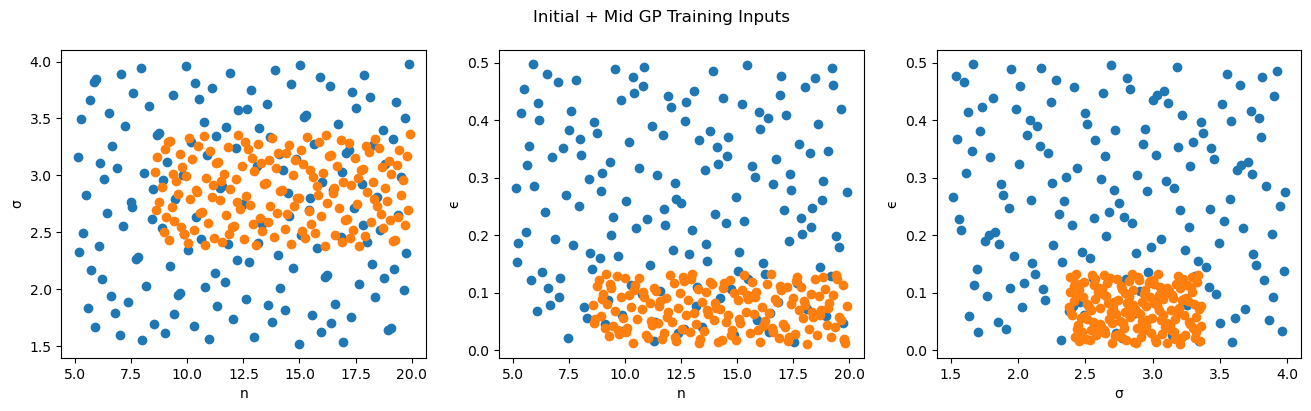

In [9]:
try: 
    input_dict = load(open('training_data/samples_mid.p', 'rb'))
    xs_mid = input_dict['xs']
    print('load success')
except:

    # Generate samples of the correct dimensions
    xs_mid = sobol((nsims, ndims))

    # Rescale them into the proper units
    ranges_mid = np.array([[max(minParamsInit[0]-8,ranges_init[0][0])   , min(minParamsInit[0]+8,ranges_init[0][1])],
                           [max(minParamsInit[1]-0.5,ranges_init[1][0]), min(minParamsInit[1]+0.5,ranges_init[1][1])],
                           [max(minParamsInit[2]-0.07,ranges_init[2][0]) , min(minParamsInit[2]+0.07,ranges_init[2][1])]])
   
    xs_mid = ranges_mid[:, 0] + xs_mid * (ranges_mid[:, 1] - ranges_mid[:, 0])

    # Save the input samples
    output_dict = dict(xs = xs_mid)
    dump(output_dict, open('training_data/samples_mid.p', 'wb'))

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.suptitle("Initial + Mid GP Training Inputs")
axs[0].scatter(xs_init[:, 0], xs_init[:, 1],label="Init")
axs[0].scatter(xs_mid[:, 0], xs_mid[:, 1],label="Mid")
axs[0].set_xlabel('n')
axs[0].set_ylabel('σ')
axs[1].scatter(xs_init[:, 0], xs_init[:, 2],label="Init")
axs[1].scatter(xs_mid[:, 0], xs_mid[:, 2],label="Mid")
axs[1].set_xlabel('n')
axs[1].set_ylabel('ϵ')
axs[2].scatter(xs_init[:, 1], xs_init[:, 2],label="Init")
axs[2].scatter(xs_mid[:, 1], xs_mid[:, 2],label="Mid")
axs[2].set_xlabel('σ')
axs[2].set_ylabel('ϵ')
plt.show()

## Simulation Loop

In [10]:
# Try to load previously computed simulation data 
try: 
    input_dict = load(open('training_data/training_rdf_mid.p', 'rb'))
    totalResults = input_dict['totalResults']
    totalTime = input_dict['totalTime']
    print('load success')

# If not run them
except:
    
    cfg.set({'distributed.scheduler.worker-ttl': None})
    client = Client(threads_per_worker=1, n_workers=40)
    
    xs_filename = 'training_data/samples_mid.p' 
    
    # Queue up function calls into dask
    lazy_results = []
    for i in range (160, 160+nsims, 1):
        lazy_results.append(dask.delayed(run_simulation)(i,xs_filename))

    t1 = time.time()

    # Split the dask calls to run 4 sets of 40 sims
    totalResults = []
    i = 0
    while i < 160:
        
        # Allow dask to parallelize the set of simulations and run them
        results = dask.compute(*lazy_results[i:(i+40)])
        totalResults.append(results)
        i += 40        

    t2 = time.time()
    totalTime = (t2-t1)

    output_dict = dict(totalResults = totalResults, totalTime = t2-t1)
    dump(output_dict, open('training_data/training_rdf_mid.p', 'wb'))
    
results = []
for result_i in totalResults:
    for outDict in result_i:
        results.append(outDict)

load success


## Results

Total Time Taken for 160 Sims:  12043.443596601486
Average Time =  75.2715224787593
Average Simulation Time:  2066.9988170415163


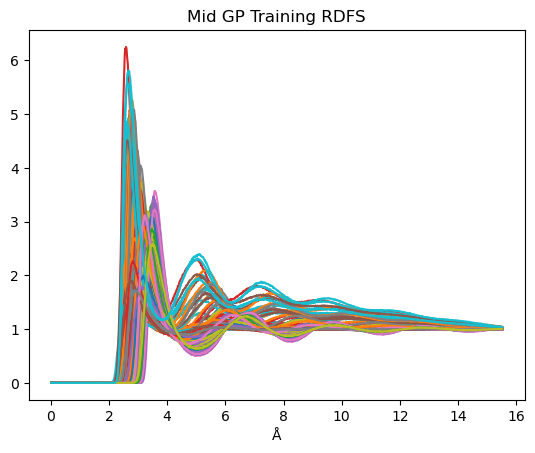

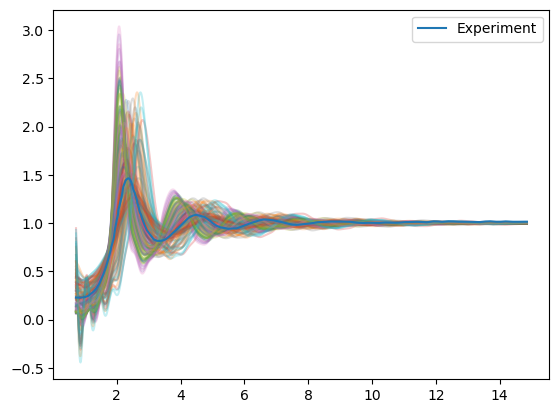

Best set of Mie parameters from training set:  [13.70239258  2.7265625   0.06214111]


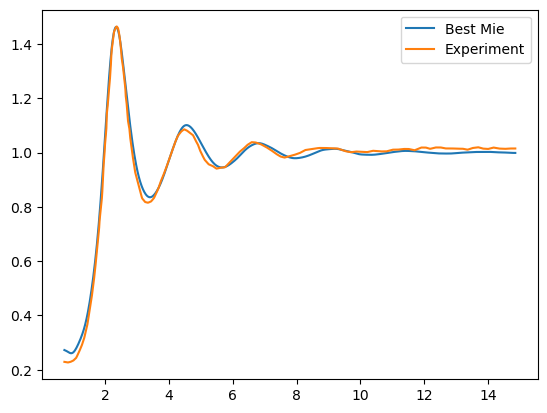

In [11]:
# Display RDFs and compute average time for simulation
print("Total Time Taken for 160 Sims: ", totalTime)
print("Average Time = ", totalTime/160)
tAvgMid = 0
modelRDFMid = np.zeros((len(xs_mid),len(results[0]['model_rdf'])))
simulationTimeMid = np.zeros(len(xs_mid))
for i in range(len(results)):
    tAvgMid += results[i]['t']
    simulationTimeMid[i] = results[i]['t']
    modelRDFMid[i] = results[i]['model_rdf']

model_rMid = results[i]['r']
print("Average Simulation Time: ", tAvgMid/len(xs_mid))

plt.plot(model_rMid, modelRDFMid.T)
plt.xlabel('Å')
plt.title("Mid GP Training RDFS")
plt.show()

try:
    input_dict = load(open('training_data/training_sq_mid.p', 'rb'))
    q = input_dict['q']
    model_sq_mid = input_dict['model_sq_mid']
    
except:
    
    # Compute the structure factor for all the simulations 
    model_sq_mid = np.zeros_like(modelRDFMid)

    q = rdf2sq(model_rMid, modelRDFMid[0], qmin, qmax, ρ)[0]
    for i in range (nsims):
        model_sq_mid[i] = rdf2sq(model_rMid, modelRDFMid[i], qmin, qmax, ρ)[1]
        
    output_dict = dict(q = q, model_sq = model_sq_mid, simulationTime = simulationTimeMid)
    dump(output_dict, open('training_data/training_sq_mid.p', 'wb'))

plt.plot(q, model_sq_mid.T, alpha = 0.25)
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

# Loop over the model structure factors to find the best one to narrow GP training range. 
minIndexMid = np.argmin([np.sum((model_sq_mid[i] - sq_exp)**2) for i in range(len(model_sq_mid))])
minParamsMid = xs_mid[minIndexMid]

print("Best set of Mie parameters from training set: ", minParamsMid)

plt.plot(q, model_sq_mid[minIndexMid], label='Best Mie')
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

## Last GP Training Set Input Space

We can recenter the training space even more to arrive at the final set of training simulations. 

load success


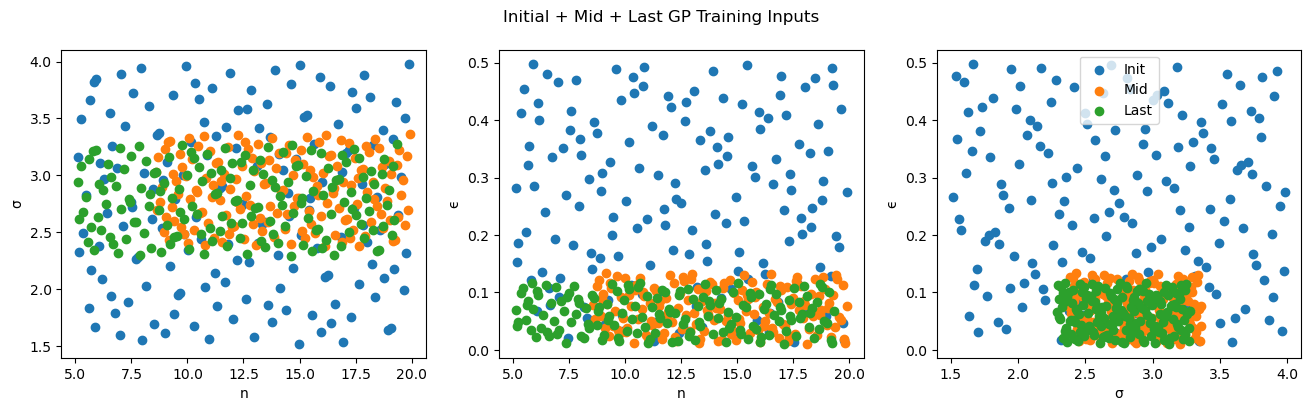

In [12]:
try: 
    input_dict = load(open('training_data/samples_last.p', 'rb'))
    xs_last = input_dict['xs']
    print('load success')
except:

    # Generate samples of the correct dimensions
    xs_last = sobol((nsims, ndims))

    # Rescale them into the proper units
    ranges_last = np.array([[max(minParamsMid[0]-5,ranges_init[0][0])   , min(minParamsMid[0]+5,ranges_init[0][1])],
                           [max(minParamsMid[1]-0.75,ranges_init[1][0]), min(minParamsMid[1]+0.75,ranges_init[1][1])],
                           [max(minParamsMid[2]-0.1,ranges_init[2][0]) , min(minParamsMid[2]+0.1,ranges_init[2][1])]])
   
    xs_last = ranges_last[:, 0] + xs_last * (ranges_last[:, 1] - ranges_last[:, 0])

    # Save the input samples
    output_dict = dict(xs = xs_last)
    dump(output_dict, open('training_data/samples_last.p', 'wb'))

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.suptitle("Initial + Mid + Last GP Training Inputs")
axs[0].scatter(xs_init[:, 0], xs_init[:, 1],label="Init")
axs[0].scatter(xs_mid[:, 0], xs_mid[:, 1],label="Mid")
axs[0].scatter(xs_last[:, 0], xs_last[:, 1],label="Last")
axs[0].set_xlabel('n')
axs[0].set_ylabel('σ')
axs[1].scatter(xs_init[:, 0], xs_init[:, 2],label="Init")
axs[1].scatter(xs_mid[:, 0], xs_mid[:, 2],label="Mid")
axs[1].scatter(xs_last[:, 0], xs_last[:, 2],label="Last")
axs[1].set_xlabel('n')
axs[1].set_ylabel('ϵ')
axs[2].scatter(xs_init[:, 1], xs_init[:, 2],label="Init")
axs[2].scatter(xs_mid[:, 1], xs_mid[:, 2],label="Mid")
axs[2].scatter(xs_last[:, 1], xs_last[:, 2],label="Last")
axs[2].set_xlabel('σ')
axs[2].set_ylabel('ϵ')
plt.legend()
plt.show()

## Simulation Loop

In [13]:
# Try to load in previously simulated data
try: 
    input_dict = load(open('training_data/training_rdf_last.p', 'rb'))
    totalResults = input_dict['totalResults']
    totalTime = input_dict['totalTime']
    print('load success')

# If not run them
except:
    cfg.set({'distributed.scheduler.worker-ttl': None})
    client = Client(threads_per_worker=1, n_workers=40)
    
    xs_filename = 'training_data/samples_last.p'

    # Queue up function calls into dask
    lazy_results = []
    for i in range (320, 320 + nsims, 1):
        lazy_results.append(dask.delayed(run_simulation)(i,xs_filename))

    # Queue up function calls into dask
    t1 = time.time()

    # Agsin split the calls into 4 sets of 40 to not overload dask.
    totalResults = []
    i = 0
    while i < 160:
        
        # Allow dask to parallelize the set of simulations and run them
        results = dask.compute(*lazy_results[i:(i+40)])
        totalResults.append(results)
        i += 40        
    t2 = time.time()
    totalTime = (t2-t1)
    
    output_dict = dict(totalResults = totalResults, totalTime = totalTime)
    dump(output_dict, open('training_data/training_rdf_last.p', 'wb'))

results = []
for result_i in totalResults:
    for outDict in result_i:
        results.append(outDict)

load success


## Results

Total Time Taken for 160 Sims:  11037.279714345932
Average Time =  68.98299821466208
Average Simulation Time:  1913.3153936445713


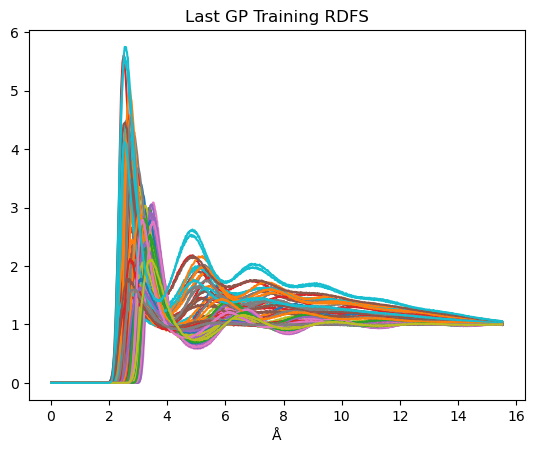

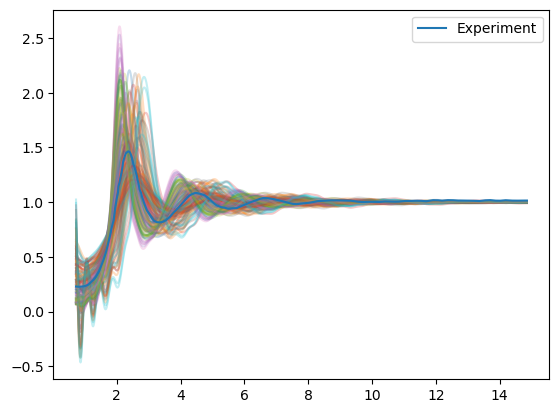

Best set of Mie parameters from training set:  [16.96909523  2.765625    0.06887518]


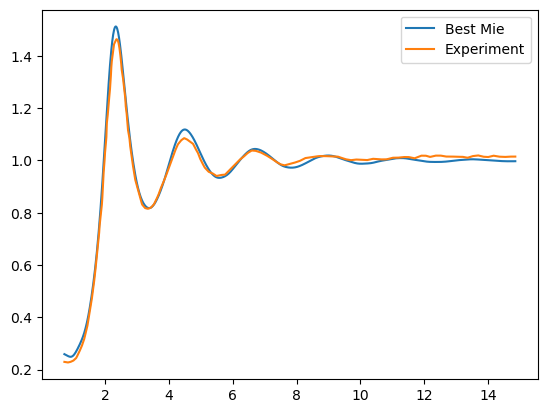

In [14]:
# Display RDFs and compute average time for simulation
print("Total Time Taken for 160 Sims: ", totalTime)
print("Average Time = ", totalTime/160)
tAvgLast = 0
modelRDFLast = np.zeros((len(xs_last),len(results[0]['model_rdf'])))
simulationTimeLast = np.zeros(len(xs_last))
for i in range(len(results)):
    tAvgLast += results[i]['t']
    simulationTimeLast[i] = results[i]['t']
    modelRDFLast[i] = results[i]['model_rdf']

model_rLast = results[i]['r']
print("Average Simulation Time: ", tAvgLast/len(xs_last))

plt.plot(model_rLast, modelRDFLast.T)
plt.xlabel('Å')
plt.title("Last GP Training RDFS")
plt.show()

try:
    input_dict = load(open('training_data/training_sq_last.p', 'rb'))
    q = input_dict['q']
    model_sq_last = input_dict['model_sq_last']
    
except:
    
    # Compute the structure factor for all the simulations 
    model_sq_last = np.zeros_like(modelRDFLast)

    q = rdf2sq(model_rLast, modelRDFLast[0], qmin, qmax, ρ)[0]
    for i in range (nsims):
        model_sq_last[i] = rdf2sq(model_rLast, modelRDFLast[i], qmin, qmax, ρ)[1]
        
    output_dict = dict(q = q, model_sq = model_sq_last, simulationTime = simulationTimeLast)
    dump(output_dict, open('training_data/training_sq_last.p', 'wb'))
    
plt.plot(q, model_sq_last.T, alpha = 0.25)
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

# Loop over the model structure factors to find the best one to narrow GP training range. 
minIndexLast = np.argmin([np.sum((model_sq_last[i] - sq_exp)**2) for i in range(len(model_sq_last))])
minParamsLast = xs_last[minIndexLast]

print("Best set of Mie parameters from training set: ", minParamsLast)

plt.plot(q, model_sq_last[minIndexLast], label='Best Mie')
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

## Compile All Training Data

In [15]:
try:
    input_dict = load(open('training_data/training_sq.p', 'rb'))
    q = input_dict['q']
    model_sq = input_dict['model_sq']
    simulationTime = input_dict['simulationTime']
    
    input_dict = load(open('training_data/samples.p', 'rb'))
    xs = input_dict['xs']
    
    input_dict = load(open('training_data/training_rdf.p', 'rb'))
    model_rdf = input_dict['model_rdf']
    
    print('load success')

except:
    
    model_sq = np.zeros((3*160,len(q)))
    model_sq[:160] = model_sq_init
    model_sq[160:320] = model_sq_mid
    model_sq[320:] = model_sq_last

    simulationTime = np.zeros(3*160)
    simulationTime[:160] = simulationTimeInit
    simulationTime[160:320] = simulationTimeMid
    simulationTime[320:] = simulationTimeLast

    output_dict = dict(q = q, model_sq = model_sq, simulationTime = simulationTime)
    dump(output_dict, open('training_data/training_sq.p', 'wb'))
    
    xs = np.zeros((160*3,3))
    xs[:160] = xs_init
    xs[160:320] = xs_mid
    xs[320:] = xs_last

    output_dict = dict(xs = xs)
    dump(output_dict, open('training_data/samples.p', 'wb'))
    
    model_rdf = np.zeros((160*3,len(model_rLast)))
    model_rdf[:160] = modelRDFInit
    model_rdf[160:320] = modelRDFMid
    model_rdf[320:] = modelRDFLast
    
    output_dict = dict(model_rdf = model_rdf, r = model_rLast)
    dump(output_dict, open('training_data/training_rdf.p', 'wb'))

load success


## Create a Testing Dataset

load success


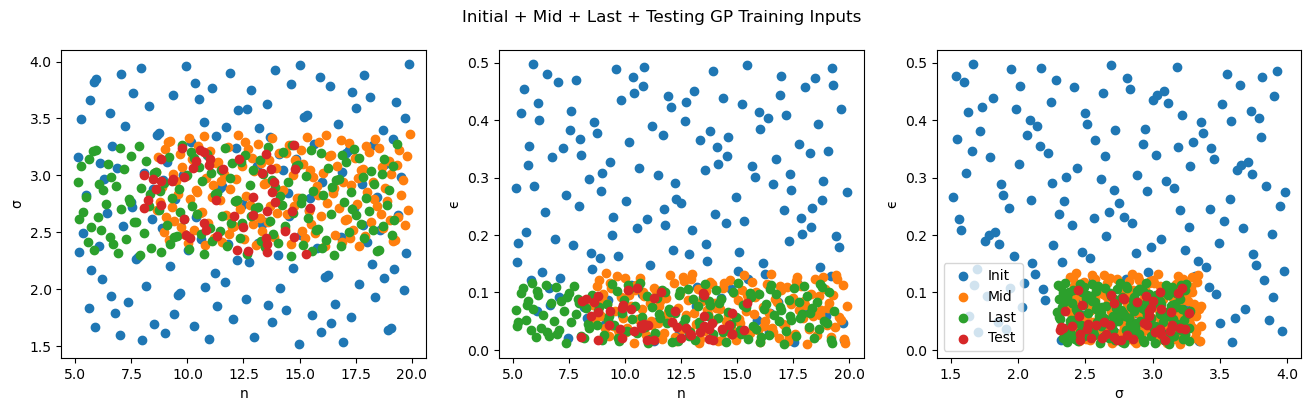

In [16]:
try: 
    input_dict = load(open('testing_data/samples_test.p', 'rb'))
    xs_test = input_dict['xs']
    print('load success')
except:

    # Generate samples of the correct dimensions
    xs_test = np.random.uniform(0,1,(50,ndims))

    # Rescale them into the proper units
    ranges_test = np.array([[max(minParamsMid[0]-4,ranges_init[0][0])   , min(minParamsMid[0]+4,ranges_init[0][1])],
                           [max(minParamsMid[1]-0.5,ranges_init[1][0]), min(minParamsMid[1]+0.5,ranges_init[1][1])],
                           [max(minParamsMid[2]-0.06,ranges_init[2][0]) , min(minParamsMid[2]+0.06,ranges_init[2][1])]])
   
    xs_test = ranges_test[:, 0] + xs_test * (ranges_test[:, 1] - ranges_test[:, 0])

    # Save the input samples
    output_dict = dict(xs = xs_test)
    dump(output_dict, open('testing_data/samples_test.p', 'wb'))
    
# Visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.suptitle("Initial + Mid + Last + Testing GP Training Inputs")
axs[0].scatter(xs_init[:, 0], xs_init[:, 1],label="Init")
axs[0].scatter(xs_mid[:, 0], xs_mid[:, 1],label="Mid")
axs[0].scatter(xs_last[:, 0], xs_last[:, 1],label="Last")
axs[0].scatter(xs_test[:, 0], xs_test[:, 1],label="Test")
axs[0].set_xlabel('n')
axs[0].set_ylabel('σ')
axs[1].scatter(xs_init[:, 0], xs_init[:, 2],label="Init")
axs[1].scatter(xs_mid[:, 0], xs_mid[:, 2],label="Mid")
axs[1].scatter(xs_last[:, 0], xs_last[:, 2],label="Last")
axs[1].scatter(xs_test[:, 0], xs_test[:, 2],label="Test")
axs[1].set_xlabel('n')
axs[1].set_ylabel('ϵ')
axs[2].scatter(xs_init[:, 1], xs_init[:, 2],label="Init")
axs[2].scatter(xs_mid[:, 1], xs_mid[:, 2],label="Mid")
axs[2].scatter(xs_last[:, 1], xs_last[:, 2],label="Last")
axs[2].scatter(xs_test[:, 1], xs_test[:, 2],label="Test")
axs[2].set_xlabel('σ')
axs[2].set_ylabel('ϵ')
plt.legend()
plt.show()

In [17]:
try: 
    input_dict = load(open('testing_data/training_rdf_test.p', 'rb'))
    results = input_dict['results']
    print('load success')

except:
    xs_filename = 'testing_data/samples_test.p'
    
    cfg.set({'distributed.scheduler.worker-ttl': None})
    client = Client(threads_per_worker=1, n_workers=50)

    # Queue up function calls into dask
    lazy_results = []
    for i in range (3*160, 3*160+50, 1):
        lazy_results.append(dask.delayed(run_simulation)(i,xs_filename))

    # Allow dask to parallelize the set of simulations and run them
    results = dask.compute(*lazy_results)

    output_dict = dict(results = results)
    dump(output_dict, open('testing_data/training_rdf_test.p', 'wb'))

load success


Average Simulation Time:  2091.097615904808


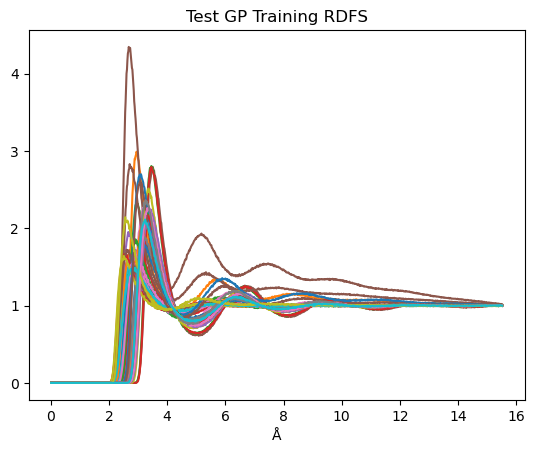

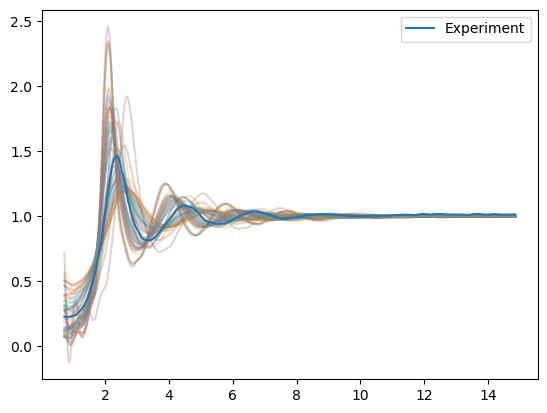

Best set of Mie parameters from testing set:  [13.48688011  3.18872272  0.09883634]


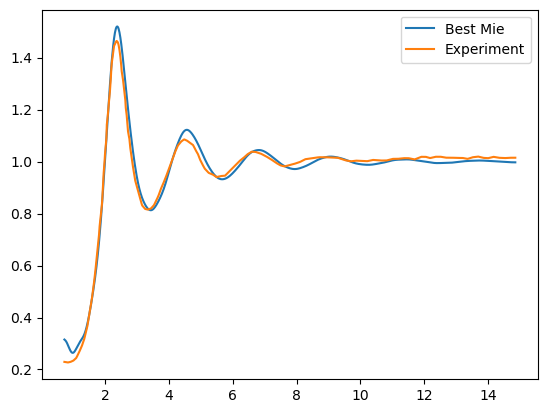

In [18]:
# Display RDFs and compute average time for simulation
tAvgTest = 0
modelRDFTest = np.zeros((len(xs_test),len(results[0]['model_rdf'])))
simulationTimeTest = np.zeros(len(xs_test))
for i in range(len(results)):
    tAvgTest += results[i]['t']
    simulationTimeTest[i] = results[i]['t']
    modelRDFTest[i] = results[i]['model_rdf']

model_rTest = results[i]['r']
print("Average Simulation Time: ", tAvgTest/len(xs_test))

plt.plot(model_rTest, modelRDFTest.T)
plt.xlabel('Å')
plt.title("Test GP Training RDFS")
plt.show()

try:
    input_dict = load(open('testing_data/testing_sq.p', 'rb'))
    q = input_dict['q']
    model_sq_last = input_dict['model_sq_test']
    
except:
    
    # Compute the structure factor for all the simulations 
    model_sq_test = np.zeros_like(modelRDFTest)

    q = rdf2sq(model_rTest, modelRDFTest[0], qmin, qmax, ρ)[0]
    for i in range (50):
        model_sq_test[i] = rdf2sq(model_rTest, modelRDFTest[i], qmin, qmax, ρ)[1]
        
    output_dict = dict(q = q, model_sq = model_sq_test, simulationTime = simulationTimeTest)
    dump(output_dict, open('testing_data/testing_sq.p', 'wb'))

plt.plot(q, model_sq_test.T, alpha = 0.25)
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

# Loop over the model structure factors to find the best one to narrow GP training range. 
minIndexTest = np.argmin([np.sum((model_sq_test[i] - sq_exp)**2) for i in range(len(model_sq_test))])
minParamsTest = xs_test[minIndexTest]

print("Best set of Mie parameters from testing set: ", minParamsTest)

plt.plot(q, model_sq_test[minIndexTest], label='Best Mie')
plt.plot(q_exp, sq_exp,label='Experiment')
plt.legend()
plt.show()

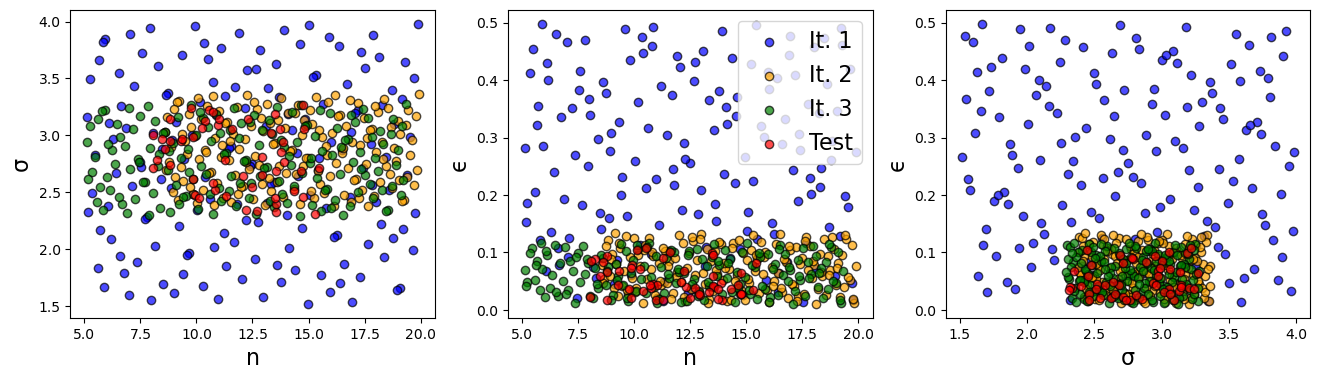

In [19]:
# Visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].scatter(xs_init[:, 0], xs_init[:, 1],label="It. 1", color = 'b', edgecolor = ['k'], alpha = 0.7)
axs[0].scatter(xs_mid[:, 0], xs_mid[:, 1],label="It. 2", color = 'orange', edgecolor = ['k'], alpha = 0.7)
axs[0].scatter(xs_last[:, 0], xs_last[:, 1],label="It. 3", color = 'g', edgecolor = ['k'], alpha = 0.7)
axs[0].scatter(xs_test[:, 0], xs_test[:, 1],label="Test", color = 'r', edgecolor = ['k'], alpha = 0.7)
axs[0].set_xlabel('n', fontsize = 16)
axs[0].set_ylabel('σ', fontsize = 16)
axs[1].scatter(xs_init[:, 0], xs_init[:, 2],label="It. 1", color = 'b', edgecolor = ['k'], alpha = 0.7)
axs[1].scatter(xs_mid[:, 0], xs_mid[:, 2],label="It. 2", color = 'orange', edgecolor = ['k'], alpha = 0.7)
axs[1].scatter(xs_last[:, 0], xs_last[:, 2],label="It. 3", color = 'g', edgecolor = ['k'], alpha = 0.7)
axs[1].scatter(xs_test[:, 0], xs_test[:, 2],label="Test", color = 'r', edgecolor = ['k'], alpha = 0.7)
axs[1].set_xlabel('n', fontsize = 16)
axs[1].set_ylabel('ϵ', fontsize = 16)
axs[1].legend(fontsize = 16)
axs[2].scatter(xs_init[:, 1], xs_init[:, 2],label="Init", color = 'b', edgecolor = ['k'], alpha = 0.7)
axs[2].scatter(xs_mid[:, 1], xs_mid[:, 2],label="Mid", color = 'orange', edgecolor = ['k'], alpha = 0.7)
axs[2].scatter(xs_last[:, 1], xs_last[:, 2],label="Last", color = 'g', edgecolor = ['k'], alpha = 0.7)
axs[2].scatter(xs_test[:, 1], xs_test[:, 2],label="Test", color = 'r', edgecolor = ['k'], alpha = 0.7)
axs[2].set_xlabel('σ', fontsize = 16)
axs[2].set_ylabel('ϵ', fontsize = 16)
# plt.savefig('trainingset', dpi = 600)
plt.show()